# Seattle Airbnb price predictions

Linear regression and random forest will be used to predict the price of stay for Airbnb listings. 

* Dependent variable -> The average price of a listing for the next year (2017). The calendar file was used to obtain average price for each listing.  

* Independent variables -> A set of variables from the listings file scraped in 2016. The 2016 price was not used as a predictor.

## Load listings file

In [1]:
if (!require(tidyverse)) install.packages('tidyverse')
if (!require(lubridate)) install.packages('lubridate')

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
FileName <- '../input/seattle/listings.csv'

In [3]:
lis <- read.csv(FileName
                , quote = '"'
                , sep = ","
                , header = T
                , stringsAsFactors = T
                , encoding ='UTF-8')


In [4]:
# Listings has 3818 rows, 92 columns

dim(lis) 

[1] 3818   92

## Drop unused columns

The Seattle AirBnB listings file has a total of 92 variables.  The following variables are dropped to produce a more manageable subset for regression and random forest.

* URLs (listing_url, thumbnail_url, medium_url, picture_url, xl_picture_url, host_url, host_thumbnail_url, host_picture_url) 
* non-informative ID (scrape_id)
* web scrape metatdata (calendar_last_scraped)
* unstructured text data (name, summary, space, description, neighborhood_overview, notes, transit, host_name, host_about, street)
* semi-structured lists which would require a large number of separate columns to capture (host_verifications, amenities)
* variables with a high percentage of null or empty fields - e.g., for square_feet 3716 out of 3813 are empty (square_feet, license)
* variables that have almost all identical values - e.g., for country_code everything is 'US'  (city, state, market, smart_location, country, experiences_offered, country_code, has_availability, requires_license, jurisdiction_names, host_acceptance_rate, is_location_exact)
* variables that are adequately expressed by another variable. e.g., 'neighborhood_cleansed’, which has ~90 responses is a more granular version of ‘Neighborhood_group_cleansed’ which has 17 responses. For simplicity, keep ‘Neighborhood_group_cleansed’ ('neighbourhood', 'neighbourhood_cleansed', 'host_listings_count', 'host_total_listings_count')





In [5]:
unused_fields <- c('listing_url'
                   ,'scrape_id'
                   ,'last_scraped'
                   ,'name'
                   ,'summary'
                   ,'space'
                   ,'description'
                   ,'experiences_offered'
                   ,'neighborhood_overview'
                   ,'notes'
                   ,'transit'
                   ,'thumbnail_url'
                   ,'medium_url'
                   ,'picture_url'
                   ,'xl_picture_url'
                   ,'host_url'
                   ,'host_name'
                   ,'host_about'
                   ,'host_acceptance_rate'
                   ,'host_thumbnail_url'
                   ,'host_picture_url'
                   ,'host_verifications'
                   ,'street'
                   ,'city'
                   ,'state'
                   ,'market'
                   ,'smart_location'
                   ,'country_code'
                   ,'country'
                   ,'is_location_exact'
                   ,'amenities'
                   ,'square_feet'
                   ,'has_availability'
                   ,'calendar_last_scraped'
                   ,'requires_license'
                   ,'license'
                   ,'jurisdiction_names'
                   ,'neighbourhood_cleansed'
                   ,'host_listings_count'
                   ,'host_total_listings_count')

lis <- lis[,-which(names(lis) %in% unused_fields)]

In [6]:
str(lis, width = 80,strict.width='cut')

'data.frame':	3818 obs. of  52 variables:
 $ id                              : int  241032 953595 3308979 7421966 278830..
 $ host_id                         : int  956883 5177328 16708587 9851441 1452..
 $ host_since                      : Factor w/ 1381 levels "","2008-11-10",..:..
 $ host_location                   : Factor w/ 121 levels "","Accra, Greater "..
 $ host_response_time              : Factor w/ 6 levels "","a few days or mor"..
 $ host_response_rate              : Factor w/ 47 levels "","100%","17%",..: 4..
 $ host_is_superhost               : Factor w/ 3 levels "","f","t": 2 3 2 2 2 ..
 $ host_neighbourhood              : Factor w/ 103 levels "","Alki","Anaheim",..
 $ host_has_profile_pic            : Factor w/ 3 levels "","f","t": 3 3 3 3 3 ..
 $ host_identity_verified          : Factor w/ 3 levels "","f","t": 3 3 3 3 3 ..
 $ neighbourhood                   : Factor w/ 82 levels "","Alki","Arbor Hei"..
 $ neighbourhood_group_cleansed    : Factor w/ 17 levels "Ballard",

## Replace NA and empty string values

In [7]:
# Drop two records that have no host info or listing ratings

lis <- lis[! lis$id %in% c('8354452','10235014'), ]

In [8]:
# replace a bad zipcode that contains a newline character 

lis$zipcode <- as.character(lis$zipcode)
lis[lis$id == 9448215,'zipcode'] <- 98122
lis[lis$id == 9448215,'zipcode'] 
lis$zipcode <- as.factor(lis$zipcode)


[1] "98122"

In [9]:
# These fields have many empty values, 
# They are mainly from the same ~650 or so records
# They can all be removed by dropping review_scores_checkin,
# review_scores_accuracy, review_scores_value

# review_scores_rating 645
# review_scores_accuracy 656
# review_scores_cleanliness 651
# review_scores_checkin 656
# review_scores_communication 649
# review_scores_location 653
# review_scores_value 654
# reviews_per_month 625
# first_review 625
# last_review 625

lis <- lis[!is.na(lis$review_scores_checkin), ]
lis <- lis[!is.na(lis$review_scores_accuracy), ]
lis <- lis[!is.na(lis$review_scores_value), ]

In [10]:
# 12 missing values for bathrooms, 6 missing values for bedrooms
# Values could be imputed with the mean for the column, 
# but since there are only 12 and 6, it will not hurt to drop them.


lis <- lis[!is.na(lis$bathrooms), ]
lis <- lis[!is.na(lis$bedrooms), ]


In [11]:
# host_location =  Seattle, Washington, United States about 85% of the time. 
# Recode as: If Seattle then 1, else 0.  
# For 6 records with empty fields, assume Seattle

lis$host_location <- as.character(lis$host_location)
lis[grepl('seattle',str_to_lower(lis$host_location)),'host_location'] <- '1'
lis[!lis$host_location=='1','host_location'] <- '0'
lis$host_location <- as.factor(lis$host_location)


In [12]:
# host-neighbourhood = neighbourhood about 88% of the time. 
# Recode as: if host-neighbourhood = neighbourhood 1, else 0
# for 298 records with empty fields, assume host-neighbourhood = neighbourhood.

lis$host_neighbourhood <- as.character(lis$host_neighbourhood)
lis$host_neighbourhood[lis$host_neighbourhood == lis$neighbourhood] <- '1'
lis$host_neighbourhood[!lis$host_neighbourhood =='1'] <- '0'
lis$host_neighbourhood <- as.factor(lis$host_neighbourhood)

In [13]:
# Bed type has 96% real bed and 4% airbed, couch, futon, pull-out sofa
# Recode as: if real bed then 1, else 0 

lis$bed_type <- as.character(lis$bed_type)
lis$bed_type[lis$bed_type == 'Real Bed'] <- '1'
lis$bed_type[!lis$bed_type =='1'] <- '0'
lis$bed_type <- as.factor(lis$bed_type)


In [14]:
# Drop neighbourhood (keeping the neighborhood_group_cleansed,
# which is a grouper for neighbourhood)

lis <- lis[ ,-which(names(lis) == 'neighbourhood') ]

In [15]:
# zipcode - 6 missing
# impute the value with the most common zipcode in the 
# neighbourhood_group_cleansed that the property is in.

# impute with the most common zipcode in the neighborhood_group_cleansed

lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Queen Anne'] <- 98109
lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Ballard'] <- 98107
lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Interbay'] <- 98119
lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Capitol Hill'] <- 98102
lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Central Area'] <- 98122
lis$zipcode[lis$zipcode=='' & lis$neighbourhood_group_cleansed=='Downtown'] <- 98101

lis$zipcode <- as.factor(lis$zipcode)


In [16]:
# Theres not an easy way to impute the values for these fields 
# and they are suffienciently captured by price, so the columns will be dropped.

# weekly_price 1806
# monthly_price 2297
# security_deposit 1948
# cleaning_fee 1028

unused_fields <- c('weekly_price','monthly_price','security_deposit','cleaning_fee')

lis <- lis[,-which(names(lis) %in% unused_fields)]

## Recode data and set datatypes

In [17]:
# Recode some t/f fields to boolean and set datatype as factor


lis$host_is_superhost <- as.character(lis$host_is_superhost)
lis$host_is_superhost[lis$host_is_superhost=='t'] <- '1'
lis$host_is_superhost[lis$host_is_superhost=='f'] <- '0'
lis$host_is_superhost <- as.factor(lis$host_is_superhost)

lis$host_has_profile_pic <- as.character(lis$host_has_profile_pic)
lis$host_has_profile_pic[lis$host_has_profile_pic=='t'] <- '1'
lis$host_has_profile_pic[lis$host_has_profile_pic=='f'] <- '0'
lis$host_has_profile_pic <- as.factor(lis$host_has_profile_pic)

lis$host_identity_verified <- as.character(lis$host_identity_verified)
lis$host_identity_verified[lis$host_identity_verified=='t'] <- '1'
lis$host_identity_verified[lis$host_identity_verified=='f'] <- '0'
lis$host_identity_verified <- as.factor(lis$host_identity_verified)

lis$instant_bookable <- as.character(lis$instant_bookable)
lis$instant_bookable[lis$instant_bookable=='t'] <- '1'
lis$instant_bookable[lis$instant_bookable=='f'] <- '0'
lis$instant_bookable <- as.factor(lis$instant_bookable)

lis$require_guest_profile_picture <- as.character(lis$require_guest_profile_picture)
lis$require_guest_profile_picture[lis$require_guest_profile_picture=='t'] <- '1'
lis$require_guest_profile_picture[lis$require_guest_profile_picture=='f'] <- '0'
lis$require_guest_profile_picture <- as.factor(lis$require_guest_profile_picture)

lis$require_guest_phone_verification <- as.character(lis$require_guest_phone_verification)
lis$require_guest_phone_verification[lis$require_guest_phone_verification=='t'] <- '1'
lis$require_guest_phone_verification[lis$require_guest_phone_verification=='f'] <- '0'
lis$require_guest_phone_verification <- as.factor(lis$require_guest_phone_verification)

In [18]:
# Update dates to intervals in months before scrape date (rounded to nearest int)

scrape_date <- ymd('2016-01-04')

lis$host_since <- ymd(lis$host_since)
lis$first_review <- ymd(lis$first_review)
lis$last_review <- ymd(lis$last_review)

lis$host_since <- interval(lis$host_since, scrape_date) 
lis$host_since <- as.numeric(lis$host_since, 'months')
lis$host_since <- round(lis$host_since)

lis$first_review <- interval(lis$first_review, scrape_date) 
lis$first_review <- as.numeric(lis$first_review, 'months')
lis$first_review <- round(lis$first_review)

lis$last_review <- interval(lis$last_review, scrape_date) 
lis$last_review <- as.numeric(lis$last_review, 'months')
lis$last_review <- round(lis$last_review)


In [19]:
# Simplify the property type variable to house, apartment, and other and set datatype as factor

lis$property_type <- as.character(lis$property_type)
lis$property_type[lis$property_type == 'House' | lis$property_type == 'Townhouse'] <- 'House'
lis$property_type[lis$property_type == 'Apartment' | lis$property_type == 'Condominium'] <- 'Apartment'
lis$property_type[lis$property_type != 'House' & lis$property_type != 'Apartment'] <- 'Other'
lis$property_type <- as.factor(lis$property_type)


In [20]:
# simplify the calendar updated variable to a boolean:
# if < 1 week then 0, else 1. Set datatype as factor


lis$calendar_updated<- as.character(lis$calendar_updated)
lis$calendar_updated[lis$calendar_updated == 'today' 
                     | lis$calendar_updated == 'yesterday'
                     | lis$calendar_updated == '2 days ago'
                     | lis$calendar_updated == '3 days ago'
                     | lis$calendar_updated == '4 days ago'
                     | lis$calendar_updated == '5 days ago'
                     | lis$calendar_updated == '6 days ago'
                     ] <- '1'
lis$calendar_updated[!lis$calendar_updated =='1'] <- '0'
lis$calendar_updated <- as.factor(lis$calendar_updated)


In [21]:
# recode host response time and set datatype as factor

lis$host_response_time <- as.character(lis$host_response_time)
lis$host_response_time[lis$host_response_time=='N/A'] <- 'unknown'
lis$host_response_time <- as.factor(lis$host_response_time)

In [22]:
# Convert the host response rate to a categorical variable 

# Prepare the data for binning:

lis$host_response_rate <- as.character(lis$host_response_rate)
lis[lis$host_response_rate == 'N/A','host_response_rate'] <- '1000' 
lis$host_response_rate <- gsub(pattern = "%",replacement = "", lis$host_response_rate)
lis$host_response_rate <- as.numeric(lis$host_response_rate)

# Place in bins according to value: 
# "unknown", "0-20%", "21-40%", "41-60%", "61-80%", "81-100%"

lis$host_response_cat <- "unknown"
lis$host_response_cat <- with(lis, ifelse(host_response_rate <= 20, "0-20%", host_response_cat))
lis$host_response_cat <- with(lis, ifelse(host_response_rate <= 40 & host_response_rate >= 21, "21-40%", host_response_cat))
lis$host_response_cat <- with(lis, ifelse(host_response_rate <= 60 & host_response_rate >= 41, "41-60%", host_response_cat))
lis$host_response_cat <- with(lis, ifelse(host_response_rate <= 80 & host_response_rate >= 61, "61-80%", host_response_cat))
lis$host_response_cat <- with(lis, ifelse(host_response_rate <= 100 & host_response_rate >= 81, "81-100%", host_response_cat))

lis$host_response_cat <- as.factor(lis$host_response_cat)

# drop the host response rate (no longer needed)

lis <- lis[,-which(names(lis) == 'host_response_rate')]

# check the categories:
table(lis$host_response_cat)


  0-20%  21-40%  41-60%  61-80% 81-100% unknown 
      2      22      62     201    2547     306 

In [23]:
# set room type and cancellation policy datatype as factor
lis$room_type <- as.factor(lis$room_type)
lis$cancellation_policy <- as.factor(lis$cancellation_policy)

In [24]:
# change price fields to numeric fields from factors

lis$price <- as.character(lis$price)
lis$price <- gsub(pattern = "\\$",replacement = " ", lis$price)
lis$price <- gsub(pattern = ",",replacement = "", lis$price)
lis$price <- as.numeric(lis$price)

lis$extra_people <- as.character(lis$extra_people)
lis$extra_people <- gsub(pattern = "\\$",replacement = " ", lis$extra_people)
lis$extra_people <- gsub(pattern = ",",replacement = "", lis$extra_people)
lis$extra_people <- as.numeric(lis$extra_people)

## Process calendar file

In [25]:
FileName <- '../input/seattle/calendar.csv'

cal <- read.csv(FileName
                , quote = '"'
                , sep = ","
                , header = T
                , stringsAsFactors = F
                , encoding ='UTF-8')

str(cal)
summary(cal)


colSums(cal=='', na.rm = TRUE)


'data.frame':	1393570 obs. of  4 variables:
 $ listing_id: int  241032 241032 241032 241032 241032 241032 241032 241032 241032 241032 ...
 $ date      : chr  "2016-01-04" "2016-01-05" "2016-01-06" "2016-01-07" ...
 $ available : chr  "t" "t" "f" "f" ...
 $ price     : chr  "$85.00" "$85.00" "" "" ...


   listing_id           date            available            price          
 Min.   :    3335   Length:1393570     Length:1393570     Length:1393570    
 1st Qu.: 3258213   Class :character   Class :character   Class :character  
 Median : 6118244   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 5550111                                                           
 3rd Qu.: 8035212                                                           
 Max.   :10340165                                                           

listing_id       date  available      price 
         0          0          0     459028

In [26]:
# drop the date field

cal <- cal[,c('listing_id','available','price')]

In [27]:
# Replace the monetary string values with numeric values
# (NAs will be produced where prices are empty strings)

cal$price <- gsub(pattern = "\\$",replacement = " ", cal$price)
cal$price <- as.numeric(cal$price)

colSums(is.na(cal))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


listing_id  available      price 
         0          0     459725

In [28]:
# change the datatype of the listing id to factor 

cal$listing_id <- as.factor(cal$listing_id)

In [29]:
# Change column name 'available' to 'avail'
# Change the coding of avail from to 1/0,
# Change the datatype of avail to numeric

colnames(cal) <- c('id','avail','price')

cal[cal$avail == 'f','avail'] <- '0'
cal[cal$avail == 't','avail'] <- '1'

cal$avail <- as.numeric(cal$avail)

In [30]:
# The following five listings were found to have some available days with no price
# These were dropped from both the calendar and listings dataframes

cal <- cal[! cal$id %in% c('3308979','2715623','7733192','2459519','4825073'),]
lis <- lis[!lis$id %in% c('3308979','2715623','7733192','2459519','4825073'),]

# remove any rows in cal_sum that have the following listing ids 
# (based on analysis of listings file)

cal <- cal[! cal$id %in% c('8354452','10235014'), ]



In [31]:
# aggregate the sum of available days and the average of price
# for every listing for all dates and merge the files.

cal_sum_all <- aggregate(avail ~ id, cal, sum)

cal_avg_all <- aggregate(price ~ id, cal, mean)

cal_avg_all$price <- round(cal_avg_all$price,2)

cal_sum <- merge(cal_sum_all, cal_avg_all, by = 'id', all.x = T)

In [32]:
# merge the calendar sums for each listing with the rest of the listing information

lis <- merge(
  x = lis
  ,y = cal_sum
  ,by.x = 'id'
  ,by.y = 'id'
  ,all.y = FALSE)

In [33]:
# update the names of the price column from the merge

colnames(lis)[which(names(lis) %in% c('price.x','price.y') )] <- c('price','price_avg')

In [34]:
# there were properties that were not available for rent in 2017 and therefore
# had no average price. 

# The average price will be imputed from the price 
# in the listings file on the scrape date multiplied by an adjustment factor

# the adjustment factor will be the mean for all listings of the 
# average price to the list price


price_ratio <- lis$price_avg/lis$price
summary(price_ratio) # 1.0711 mean; 1.0000 median
rm(price_ratio)

lis[is.na(lis$price_avg),'price_avg'] <- lis$price[is.na(lis$price_avg)] * 1.0711

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.3675  1.0000  1.0000  1.0783  1.0740  3.1395      70 

In [35]:
# Create some categorical variables for price average and availability

if (!require(binr)) install.packages('binr')

Loading required package: binr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘binr’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [36]:
library(binr)

In [37]:
# Create PriceCat 

price_bins <- bins.quantiles(lis$price_avg, target.bins = 4, max.breaks = 4)
price_bins$binlo
price_bins$binhi
price_bins$binct
rm(price_bins)


lis$PriceCat <- 0
lis$PriceCat[lis$price_avg >=25 & lis$price_avg <=77.04] <- 1
lis$PriceCat[lis$price_avg >=77.18 & lis$price_avg <=109] <- 2
lis$PriceCat[lis$price_avg >=109.29 & lis$price_avg <=163.36] <- 3
lis$PriceCat[lis$price_avg >=162.62 & lis$price_avg <=1070.0289] <- 4

lis$PriceCat <- as.factor(lis$PriceCat)

[1]    1  407  857 1372

[1]  406  856 1371 1993

[25, 77.04]        [77.18, 109]    [109.29, 162.36] [162.62, 1070.0289] 
                784                 786                 781                 784

## Random forest regression model

In [38]:
library(randomForest)
library(caret)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [39]:
# move price_avg to first column for convenience

lis.price <- cbind(price_avg = lis[,'price_avg'],lis[,-which(names(lis) =='price_avg')])

In [40]:
# drop fields that will not be used by the model

fields.remove <- c('id'
                   ,'host_id'
                   ,'avail'
                   ,'price'
                   ,'weekly_price'
                   ,'monthly_price'
                   ,'security_deposit'
                   ,'cleaning_fee'
                   ,'extra_people'
                   ,'PriceCat')

lis.price <- lis.price[,-which(names(lis.price) %in% fields.remove)]
rm(fields.remove)

In [41]:
# Create k-folds for k-fold validation

# Number of observations
N <- nrow(lis.price)

# Number of desired splits
kfolds <- 5

# Generate indices of holdout observations
holdout <- split(sample(1:N), 1:kfolds)

In [42]:
#  Random Forest

results<-list()
labels<-list()

for (k in 1:kfolds){
  
  test=lis.price[holdout[[k]], ]
  train=lis.price[-holdout[[k]], ]
  
  model <- randomForest(price_avg~., data=train, ntree=250, nodesize=5, maxnodes=256)
  pred <- predict(model, test[-1])
  
  ## Accumulate results from each fold
  results<- c(results, pred)
  labels<- c(labels, test$price_avg)
  
}

In [43]:
# Unpack the results of the cross-validations

x<-unlist(labels)
str(x)

y<-unlist(results)
str(y)

results.df <- data.frame(pred=y, price_avg=x)
head(results.df)

 num [1:3135] 125 111.9 40 262.4 92.7 ...
 Named num [1:3135] 121.4 95.3 41.7 190.4 104.4 ...
 - attr(*, "names")= chr [1:3135] "746" "130" "950" "901" ...


,pred,price_avg
,<dbl>,<dbl>
746,121.37838,125.00
130,95.27496,111.86
950,41.74762,40.00
901,190.43498,262.35
160,104.35041,92.73
1267,107.86585,102.81


In [44]:
# Get MSE
results.df$resid <- results.df$pred - results.df$price_avg
mean(results.df$resid^2)

[1] 2693.015

In [45]:
# Get R-squared
y.hat <- mean(results.df$price_avg)

r.squared.num <- sum((results.df$resid)^2) 
r.squared.den <- sum((results.df$price_avg-y.hat)^2)
r.squared <- 1 - (r.squared.num/r.squared.den)
r.squared

[1] 0.7037044

[1] 250

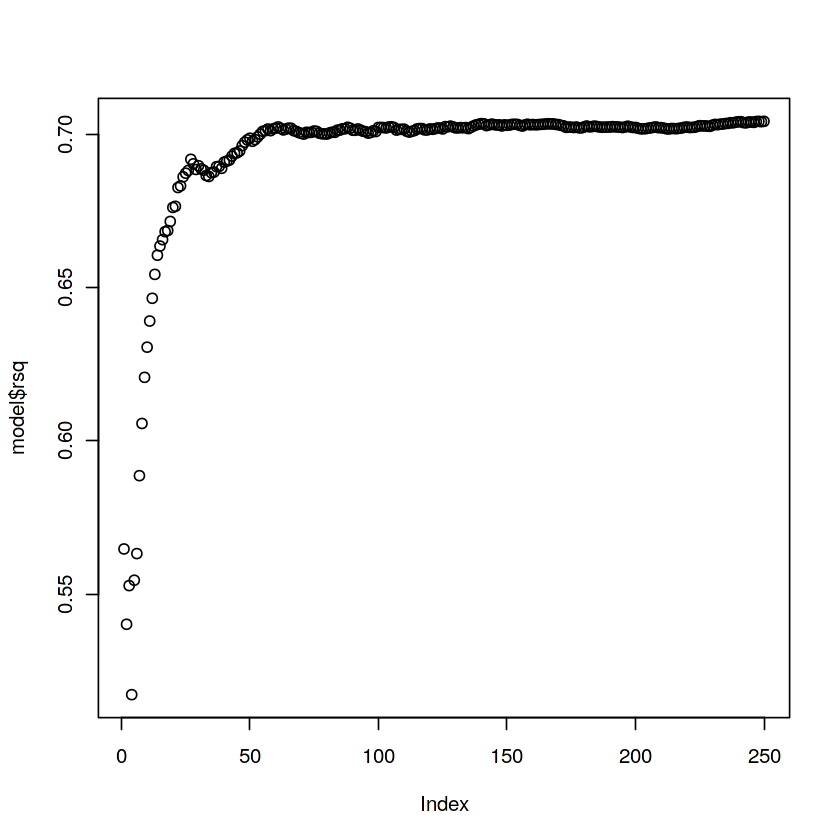

In [46]:
plot(model$rsq)
which.min(model$mse)

In [47]:
# Get variable importance of the model

im <- sort(model$importance[,1])
imDf = data.frame(name = names(im), rank = im)
imDf = imDf[order(-im), ]
imDf

,name,rank
,<fct>,<dbl>
bedrooms,bedrooms,4229402.158
accommodates,accommodates,3344970.313
bathrooms,bathrooms,2267846.657
beds,beds,2181995.532
zipcode,zipcode,1715665.333
room_type,room_type,1410022.636
neighbourhood_group_cleansed,neighbourhood_group_cleansed,982564.652
reviews_per_month,reviews_per_month,462562.431
availability_365,availability_365,400764.224


## Linear regression model


The model was generated as follows:
* All variables used, but variable interactions not used.
* Variables with a p value greater than 0.1 are dropped.
* Variable with VIF > 10 are dropped

In [48]:
library(car)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [49]:
LinearModel <- lm(price_avg ~ host_is_superhost + host_has_profile_pic + zipcode +
                      property_type + room_type + accommodates + bedrooms + bathrooms + guests_included +
                      availability_90 + availability_365 + first_review + last_review + review_scores_rating +
                      review_scores_accuracy + review_scores_location + review_scores_value + cancellation_policy +
                      reviews_per_month, data = lis.price)
summary(LinearModel)


Call:
lm(formula = price_avg ~ host_is_superhost + host_has_profile_pic + 
    zipcode + property_type + room_type + accommodates + bedrooms + 
    bathrooms + guests_included + availability_90 + availability_365 + 
    first_review + last_review + review_scores_rating + review_scores_accuracy + 
    review_scores_location + review_scores_value + cancellation_policy + 
    reviews_per_month, data = lis.price)

Residuals:
    Min      1Q  Median      3Q     Max 
-277.30  -25.82   -1.79   19.85  905.37 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   8.482545  32.960061   0.257 0.796919    
host_is_superhost1           12.397753   2.494251   4.971 7.04e-07 ***
host_has_profile_pic1       -60.540777  24.672434  -2.454 0.014191 *  
zipcode98102                -38.354247   5.482419  -6.996 3.22e-12 ***
zipcode98103                -56.140677   5.496319 -10.214  < 2e-16 ***
zipcode98104                -11.110158   7.604328  

In [50]:
# vif from car library
vif(LinearModel)

,GVIF,Df,GVIF^(1/(2*Df))
host_is_superhost,1.184595,1,1.088391
host_has_profile_pic,1.015022,1,1.007483
zipcode,2.499223,26,1.017771
property_type,1.870348,2,1.169447
room_type,1.830070,2,1.163100
accommodates,3.757212,1,1.938353
bedrooms,3.348424,1,1.829870
bathrooms,1.727220,1,1.314237
guests_included,1.501158,1,1.225217
availability_90,1.610255,1,1.268958


In [51]:
# Get model MSE

a <- fitted(LinearModel)
names(a) <- NULL

b <- lis.price[,'price_avg']

results.df <- data.frame(pred=a, price_avg=b)
head(results.df)

results.df$resid <- results.df$pred - results.df$price_avg
mean(results.df$resid^2)

,pred,price_avg
,<dbl>,<dbl>
1,54.60839,82.00
2,59.00203,53.94
3,109.52991,92.85
4,158.64823,85.00
5,97.77465,85.62
6,115.36048,113.74


[1] 2947.978

In [ ]:
library(relaimpo)

In [ ]:
relaimpo_LM <- calc.relimp(LinearModel,type=c("lmg"), rela=T) 
relaimpo_LM_df <- data.frame(relaimpo_LM@lmg)
relaimpo_LM_df <- data.frame(names = rownames(relaimpo_LM_df), rank = relaimpo_LM_df$relaimpo_LM.lmg)
relaimpo_LM_df = relaimpo_LM_df[order(-relaimpo_LM_df$rank), ]
relaimpo_LM_df

In [53]:
###  Linear regression with 5-fold cross-validation 
# (using same K-folds as random forest)

results<-list()
labels<-list()

for (k in 1:kfolds){
  
  test=lis.price[holdout[[k]], ]
  train=lis.price[-holdout[[k]], ]
  
  LinearModel.3 <- lm(price_avg ~ host_is_superhost + host_has_profile_pic + zipcode +
                        property_type + room_type + accommodates + bedrooms + bathrooms + guests_included +
                        availability_90 + availability_365 + first_review + last_review + review_scores_rating +
                        review_scores_accuracy + review_scores_location + review_scores_value + cancellation_policy +
                        reviews_per_month, data = train)
  pred <- predict(LinearModel.3, test)
  
  
  ## Accumulate results from each fold
  results<- c(results, pred)
  labels<- c(labels, test$price_avg)
}


In [54]:
# Unpack the cross-validation results

x<-unlist(labels)
str(x)

y<-unlist(results)
str(y)


results.df <- data.frame(pred=y, price_avg=x)
head(results.df)


 num [1:3135] 125 111.9 40 262.4 92.7 ...
 Named num [1:3135] 115.2 312.2 16.4 198.7 75.5 ...
 - attr(*, "names")= chr [1:3135] "746" "130" "950" "901" ...


,pred,price_avg
,<dbl>,<dbl>
746,115.21050,125.00
130,312.23170,111.86
950,16.39864,40.00
901,198.70048,262.35
160,75.52063,92.73
1267,88.79034,102.81


In [55]:
# Get cross-validated MSE
results.df$resid <- results.df$pred - results.df$price_avg
mean(results.df$resid^2)

[1] 3097.182

In [56]:
# Get cross-validated R-squared
y.hat <- mean(results.df$price_avg)
y.hat

r.squared.num <- sum((results.df$resid)^2) 
r.squared.den <- sum((results.df$price_avg-y.hat)^2)
r.squared <- 1 - (r.squared.num/r.squared.den)
r.squared


[1] 135.6943

[1] 0.6592364